# hide_toggle() setup

In [2]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# import data, derive parameters

In [31]:
import csv

frb, telescope, snr, f_p, d_L, z = [], [], [], [], [], []

with open('frb.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        line_count += 1
        if float(row[2]) > 6:
            frb.append(row[0])
            telescope.append(row[1])
            snr.append(float(row[2]))
            f_p.append(float(row[3]))
            d_L.append(float(row[4]))
            z.append(float(row[5]))
        '''
        else: 
            frb.append(row[0])
            telescope.append(row[1])
            snr.append(6)
            f_p.append(float(row[3]))
            d_L.append(float(row[4]))
            z.append(float(row[5]))
        '''
    print(f'Processed {line_count} lines.')
    
hide_toggle()

Processed 64 lines.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import math

#Deriving New Parameters
f_lim = []
L_p = []
L_plim = []

for i in range(len(f_p)):
    f_lim_i = f_p[i]/(snr[i])
    L_p_i = (f_p[i]*1e-26)*4*math.pi*(d_L[i]*3.08567758e25)**2
    L_plim_i = (f_lim_i*1e-26)*4*math.pi*(d_L[i]*3.08567758e25)**2
    f_lim.append(f_lim_i)
    L_p.append(L_p_i)
    L_plim.append(L_plim_i)

hide_toggle()

In [33]:
telescope = [telescope[i].lower() for i in range(len(telescope))] #removing the uppercase Parkes
set(telescope)

hide_toggle()

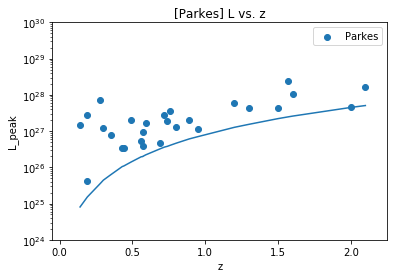

In [36]:
tel = slice(27,54)
telname = 'Parkes'
F_LIM = 0.15

L_cutoffs = []
for i in range(len(z)):
    L_cutoffs.append(L_lim1(F_LIM, z[i], d_L[i], g=g_new, k=0))

fig, ax = plt.subplots()
plt.yscale('log')
ax.scatter(z[tel], L_p[tel], label=telname)
ax.plot(sorted(z[tel]), sorted(L_cutoffs[tel]))
ax.set_ylim([1e24, 1e30])
ax.set_xlim([-0.05, 2.25])
ax.set_xlabel('z')
ax.set_ylabel('L_peak')
ax.set_title('['+ telname+ '] L vs. z')
ax.legend()

hide_toggle()

In [35]:
def g_new(z, k):
    Z = z+1
    Z_c = 3.5
    return Z**k/(1+Z/Z_c)**k

def L_lim1(F_lim, z_i, d_Li, g=g_new, k=0):
    return (F_lim*1e-26)*4*math.pi*(d_Li*3.08567758e25)**2/g(z_i, k)

hide_toggle()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math

def sort_by_first(A, B, reverse=False): #SORT USING Z!
    list1, list2 = zip(*sorted(zip(A, B), reverse=reverse))
    return list(list1), list(list2)

#original setup of Kendall Tau, using a generic F_lim,z --> L converter

def kendall_tau(L, z, F_lim, srted=False, func=L_lim1):
    
    #if necessary, sort by z while keeping reference to L
    if not srted:
        z, L = sort_by_first(z, L)
        
    R = []
    E = []
    V = []
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        if(L[i] < func(F_lim, z[i])): #don't include sources that are not above flux limit
            continue
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_lim, z[i]) and z[j] <= z[i]): #associated set requirements
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

In [38]:
def kt_newform(L, z, F_lim, d_L, g=g_new, k=0, func=L_lim1):
    
    #if necessary, sort by z while keeping reference to L
    z, L = sort_by_first(z, L)
        
    R = []
    E = []
    V = []
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        #not considering data points under the cutoff
        #if(L[i] < func(F_lim, z[i], d_L[i], g=g, k=k)):
        #    print(i)
        #    continue
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_lim, z[i], d_L[i], g=g, k=k) and z[j] <= z[i]): #associated set requirements
                
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

In [39]:
def new_L(L, z, k=0, g=g_new):
    return [L[i]/g(z[i], k) for i in range(len(L))]

def tau_k(L_p, z, k, F_lim, d_L, func=L_lim1, g=g_new):
    L_new = new_L(L_p, z, k=k, g=g)
    return kt_newform(L_new, z, F_lim, d_L, func=func)

def tkgraph(L_p, z, F_lim, d_L, func=L_lim1, g=g_new, k_min=-1, k_max=7, dk=0.01):
    #the current k value
    k = k_min

    #list of k, tau
    list_k = []
    list_t = []

    k1 = k_min #k closest to tau = 1
    kn1 = k_min #k closest to tau = -1
    k0 = k_min #k closest to t=0

    dif1 = 1e300 #smallest distance so far to tau = 1
    difn1 = 1e300 #smallest distance so far to tau = -1
    dif0 = 1e300

    while(k <= k_max):
        list_k.append(k)
        t_k = tau_k(L_p, z, k, F_lim, d_L, func=func, g=g)
        list_t.append(t_k)

        if(abs(t_k-1) < dif1):
            dif1 = abs(t_k-1)
            k1 = k
        if(abs(t_k+1) < difn1):
            difn1 = abs(t_k+1)
            kn1 = k
        if(abs(t_k) < dif0):
            dif0 = abs(t_k)
            k0 = k

        k += dk
    
    return list_k, list_t, k1, kn1, k0

hide_toggle()

In [40]:
tel = slice(27, 54) #ASKAP: (0, 27)  Parkes: (27, 54)  CHIME: (54, 62)
F_LIM = 0.15      #ASKAP: 7.7      Parkes: 0.15      CHIME: 0.30
telname = 'Parkes'

#set k values
k_min = -50
k_max = 50
dk = 0.01

list_k, list_t, k1, kn1, k0 = tkgraph(L_p[tel], z[tel], F_lim=F_LIM, d_L=d_L[tel], g=g_new, k_min=k_min, 
                                     k_max=k_max, dk=dk)

hide_toggle()

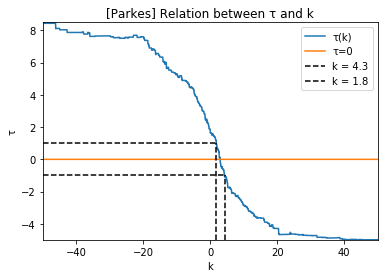

In [41]:
k1, kn1, k0 = round(k1, 2), round(kn1, 2), round(k0, 2)

YMAX, YMIN = max(list_t), min(list_t)
XMAX, XMIN = k_max, k_min
MAR = 0 #margin
XMAR = MAR/10 * (abs(XMAX)+abs(XMIN)) #scaling the xmargin
YMAR = MAR/10 * (abs(YMAX)+abs(YMIN)) #scaling the ymargin

PLOT_LINES = True

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(list_k, list_t, label='τ(k)')
ax.plot(list_k, [0 for i in range(len(list_k))], label='τ=0')

if PLOT_LINES:
    ax.plot([k1 for i in range(11)], [YMIN+(1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(kn1))
    ax.plot([kn1 for i in range(11)], [YMIN+(-1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(k1))
    ax.plot([XMIN + (k1-XMIN)*i/10 for i in range(11)],[1 for i in range(11)], color='black', linestyle='--')
    ax.plot([XMIN + (kn1-XMIN)*i/10 for i in range(11)],[-1 for i in range(11)], color='black', linestyle='--')

ax.set_ylim([YMIN-YMAR, YMAX+YMAR])
ax.set_xlim([XMIN-XMAR, XMAX+XMAR])
ax.set_xlabel('k')  # Add an x-label to the axes.
ax.set_ylabel('τ')  # Add a y-label to the axes.
ax.plot()

ax.set_title("[" + telname + "] Relation between τ and k")  # Add a title to the axes.
ax.legend()  # Add a legend.
hide_toggle()

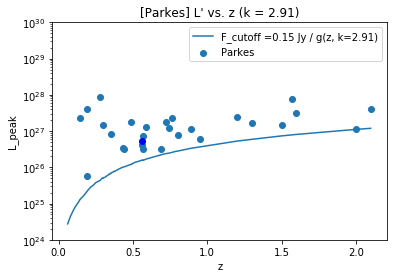

In [42]:
K = k0

L_cutoffs = []
for i in range(len(z)):
    L_cutoffs.append(L_lim1(F_LIM, z[i], d_L[i], g=g_new, k=K))

z_throwaway, L_cutoffs = sort_by_first(z, L_cutoffs)

fig, ax = plt.subplots()
plt.yscale('log')
ax.scatter(z[tel], new_L(L_p[tel], z[tel], k=K, g=g_new), label=telname)
ax.plot(z_throwaway, L_cutoffs, label='F_cutoff ='+str(F_LIM) + ' Jy / g(z, k=' + str(K) + ")")
ax.set_ylim([1e24, 1e30])
#ax.set_xlim([-0.05, 2.25])
ax.set_xlabel('z')
ax.set_ylabel('L_peak')
ax.set_title('['+ telname+ '] L\' vs. z (k = ' + str(K) + ')')

randnum = 35
idx = np.argwhere(np.diff(np.sign(np.array(L_cutoffs) - L_p[randnum]))).flatten()
#plt.plot(np.array(z_throwaway)[idx], np.array(L_cutoffs)[idx], 'ro')
plt.plot(z[randnum], L_p[randnum], 'bo')
ax.legend()

hide_toggle()

4.15212543936665e+25

In [43]:
L_prime = new_L(L_p[tel], z[tel], k=2.91, g=g_new)

In [44]:
def sigma_z(L, z, F_lim, d_L, func=L_lim1, g=g_new): #z0 being the z of interest
    z, L = sort_by_first(z, L)
    m = []
    for i in range(len(L)):
        num = 0
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_lim, z[i], d_L[i], g=g) and z[j] <= z[i]): #associated set requirements
                num += 1
        
        m.append(num+1) #includes itself?
    
    sigma = []
    prod = 1
    for j in range(len(L)):
        prod *= (1 + 1/m[j])
        sigma.append(prod)
    
    return sigma, z

In [45]:
sigma, z_ = sigma_z(L_p[tel], z[tel], 0.15, d_L[tel])

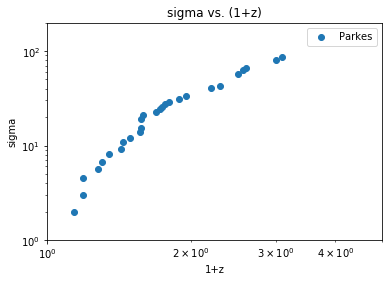

In [46]:

fig, ax = plt.subplots()
plt.yscale('log')
plt.xscale('log')
plt.ylim([1, 200])
plt.xlim([1, 5])
ax.scatter(1 + np.array(z_), sigma, label=telname)
ax.set_xlabel('1+z')
ax.set_ylabel('sigma')
ax.set_title('sigma vs. (1+z)')
ax.legend()

hide_toggle()

In [47]:
for s in z_:
    print(s)

0.14
0.19
0.19
0.28
0.3
0.35
0.43
0.44
0.49
0.56
0.57
0.57
0.59
0.69
0.72
0.74
0.76
0.8
0.89
0.95
1.2
1.3
1.5
1.57
1.6
2.0
2.1


In [48]:
logz = np.log10(1+np.array(z_))
logS = np.log10(sigma)

args = np.polyfit(logz, logS, 2)
print(args)

[-7.50444804  7.41720043  0.03419661]


In [49]:
def unpack(args, logz):
    poly = np.zeros(len(logz))
    for j in range(len(args)):
        power = len(args)-j-1
        poly += args[j]*(logz**power)
    return poly
            

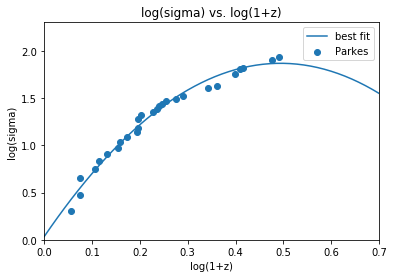

In [50]:
fig, ax = plt.subplots()
plt.ylim([0, 2.3])
plt.xlim([0, 0.7])
ax.scatter(logz, logS, label=telname)
ax.plot(np.linspace(0, 0.7, 50), unpack(args, np.linspace(0, 0.7, 50)), label='best fit')
ax.set_xlabel('log(1+z)')
ax.set_ylabel('log(sigma)')
ax.set_title('log(sigma) vs. log(1+z)')
ax.legend()

In [51]:
def manual_dL(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    return integral*(1+z)*d_H

In [52]:
def manual_Llim(F_lim, z_i, g=g_new, k=0):
    return (F_lim*1e-26)*4*math.pi*(manual_dL(z_i))**2/g(z_i, k)

In [53]:
def print_progress(i, l, prefix='PROGRESS:', suffix='COMPLETE', decimals=1, length=50, fill='█', empty='-'):
    blocks = int(i*length/l)
    spaces = length-blocks
    percent = round(100*i/l,decimals)
    bar = blocks*fill + spaces*empty
    print(f"\r{prefix} |{bar}| {percent}% {suffix}", end=' ')

In [54]:
#manually takes a while, so separate cell

L_cutoffs = []

zrange = np.linspace(0, 2.25, num=2000)

for i in range(len(zrange)):
    L_cutoffs.append(manual_Llim(F_LIM, zrange[i], g=g_new, k=K))
    print_progress(i+1, len(zrange))

PROGRESS: |██████████████████████████████████████████████████| 100.0% COMPLETE 

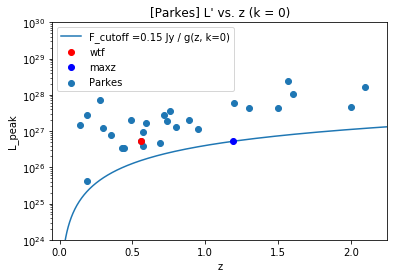

In [55]:
K = 0

zrange, L_cutoffs = sort_by_first(zrange, L_cutoffs)

fig, ax = plt.subplots()
plt.yscale('log')
ax.scatter(z[tel], new_L(L_p[tel], z[tel], k=K, g=g_new), label=telname)
ax.plot(zrange, L_cutoffs, label='F_cutoff ='+str(F_LIM) + ' Jy / g(z, k=' + str(K) + ")")
ax.set_ylim([1e24, 1e30])
ax.set_xlim([-0.05, 2.25])
ax.set_xlabel('z')
ax.set_ylabel('L_peak')
ax.set_title('['+ telname+ '] L\' vs. z (k = ' + str(K) + ')')

randnum = 35
ax.plot(z[randnum], L_p[randnum], 'ro', label ='wtf')
ax.plot(zrange[1056], L_cutoffs[1056], 'bo', label='maxz')
ax.legend()

hide_toggle()

In [56]:
L_cutoffs[745]

3.024880746990346e+26

In [57]:
L_p[randnum]

5.21193301151538e+26

In [58]:
max(z[tel])

2.1

In [59]:
def get_max_z(zrange, L_cutoffs, L):
    idx = np.argwhere(np.diff(np.sign(np.array(L_cutoffs) - L))).flatten()
    if(len(idx) < 1):
        return 1e300
    return np.array(zrange)[idx][0]

In [60]:
get_max_z(zrange, L_cutoffs, L_p[randnum])

1.1885942971485743

In [61]:
L_prime = new_L(L_p[tel], z[tel], k=2.91, g=g_new)
L_prime

[1.4472994122953383e+27,
 3.149110064114112e+26,
 6.0908053794960286e+26,
 5.865482873584374e+25,
 8.740274167770368e+27,
 1.8159498954351517e+27,
 2.2498860376798284e+27,
 2.2256499259443295e+27,
 4.176824607831405e+26,
 1.1166276435698347e+27,
 3.352975247400746e+26,
 1.695790994063613e+27,
 1.209695487749351e+27,
 8.530399950576744e+26,
 3.249826583115173e+26,
 1.2662229221298476e+27,
 3.2103441136431715e+26,
 7.303858074135388e+26,
 1.8022066133664358e+27,
 2.4689301624754303e+27,
 1.4725566299164962e+27,
 7.84240832484191e+26,
 3.974402397516345e+27,
 7.757189246650208e+27,
 3.94847139782753e+27,
 1.1125823831715643e+27,
 3.233311801769861e+27]

In [62]:
z[tel]

[0.3,
 0.57,
 0.95,
 0.19,
 0.28,
 0.72,
 0.14,
 0.76,
 0.56,
 0.89,
 0.43,
 1.3,
 0.74,
 0.35,
 0.69,
 0.59,
 0.44,
 0.57,
 0.49,
 1.2,
 1.5,
 0.8,
 2.1,
 1.57,
 0.19,
 2.0,
 1.6]

In [63]:
cutoffs_prime= new_L(L_cutoffs, zrange, k=2.91, g=g_new)
cutoffs_prime

[0.0,
 1.8296081893740102e+21,
 7.294157195669621e+21,
 1.6261189494606244e+22,
 2.885576313905025e+22,
 4.48188257047085e+22,
 6.44022688697897e+22,
 8.722237935310067e+22,
 1.1365608001922253e+23,
 1.4347900060372408e+23,
 1.7634460357077807e+23,
 2.128143096453171e+23,
 2.5220015286838975e+23,
 2.9518418379807898e+23,
 3.4095985458940316e+23,
 3.903281279329477e+23,
 4.423655576376101e+23,
 4.979903242133249e+23,
 5.567104846634584e+23,
 6.179195437889463e+23,
 6.827086486217466e+23,
 7.49869060303651e+23,
 8.206050056639974e+23,
 8.935965651763084e+23,
 9.701594303004605e+23,
 1.0488640846152711e+24,
 1.1311360908954494e+24,
 1.2162325988375537e+24,
 1.3033033692110735e+24,
 1.393936087593004e+24,
 1.486433781589383e+24,
 1.5824901161042053e+24,
 1.680303901736489e+24,
 1.7816732633724691e+24,
 1.8846942850731656e+24,
 1.9912680527909708e+24,
 2.1004164916816684e+24,
 2.2110608787814938e+24,
 2.32525422178655e+24,
 2.440841934912481e+24,
 2.55997632495309e+24,
 2.6804051434657163e+

In [64]:
def phi_L(Lprime, z, zrange, cutoffs_prime, func=L_lim1, g=g_new): #z0 being the z of interest
    Lprime, z = sort_by_first(Lprime, z, reverse=True)
    n = []
    for i in range(len(z)):
        num = 0
        
        z_max = get_max_z(zrange, cutoffs_prime, Lprime[i])
        for j in range(0, i): #since sorted by largest L' to smallest
                            #should only include L'[j] > L'[i]
                
            if(Lprime[j] >= Lprime[i] and z[j] <= z_max): #associated set requirements
                num += 1
        
        n.append(num+1) #includes itself?
    
    phi = []
    prod = 1
    for k in range(len(z)):
        prod *= (1 + 1/n[k])
        phi.append(prod)
    
    return phi, Lprime

In [65]:
phi, Lprime = phi_L(L_prime, z[tel], zrange, cutoffs_prime)

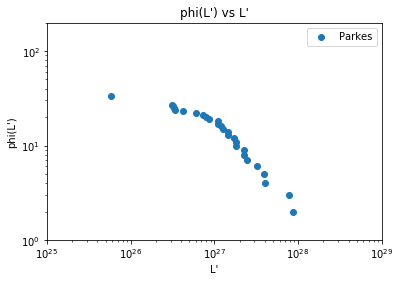

In [66]:
fig, ax = plt.subplots()
plt.yscale('log')
plt.xscale('log')
plt.ylim([1, 200])
plt.xlim([1e25, 1e29])
ax.scatter(Lprime, phi, label=telname)
ax.set_xlabel('L\'')
ax.set_ylabel('phi(L\')')
ax.set_title('phi(L\') vs L\'')
ax.legend()


In [44]:
for p in Lprime:
    print(p)

8.740274167770368e+27
7.757189246650208e+27
3.974402397516345e+27
3.94847139782753e+27
3.233311801769861e+27
2.4689301624754303e+27
2.2498860376798284e+27
2.2256499259443295e+27
1.8159498954351517e+27
1.8022066133664358e+27
1.695790994063613e+27
1.4725566299164962e+27
1.4472994122953383e+27
1.2662229221298476e+27
1.209695487749351e+27
1.1166276435698347e+27
1.1125823831715643e+27
8.530399950576744e+26
7.84240832484191e+26
7.303858074135388e+26
6.0908053794960286e+26
4.176824607831405e+26
3.352975247400746e+26
3.249826583115173e+26
3.2103441136431715e+26
3.149110064114112e+26
5.865482873584374e+25


In [41]:
logL = np.log10(Lprime)
logP = np.log10(phi)

args = np.polyfit(logL, logP, 2)
print(args)

[  -0.33119575   17.24837765 -223.0512902 ]


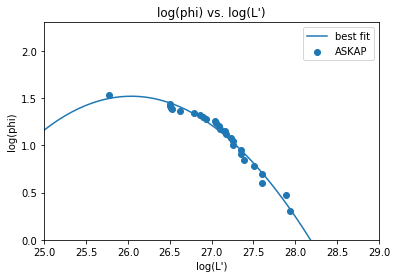

In [42]:
fig, ax = plt.subplots()
plt.ylim([0, 2.3])
plt.xlim([25, 29])
ax.scatter(logL, logP, label=telname)
ax.plot(np.linspace(25, 29, 50), unpack(args, np.linspace(25, 29, 50)), label='best fit')
ax.set_xlabel('log(L\')')
ax.set_ylabel('log(phi)')
ax.set_title('log(phi) vs. log(L\')')
ax.legend()

## man

In [ ]:
def manual_V(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    return integral*(1+z)*d_H